In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import pickle

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
slides_train = ["BAL_Cat_Turnbull blue_1.svs", 
                         "BAL_Cat_Turnbull blue_6.svs", 
                         "BAL_Cat_Turnbull blue_14.svs", 
                         "BAL_Cat_Turnbull blue_13.svs", 
                         "BAL_Cat_Turnbull blue_2.svs", ]

slides_val = list(set(["BAL_Cat_Turnbull blue_12.svs", "BAL_Cat_Turnbull blue_10.svs"]))

In [7]:
grade_list = [0, 1]
annotations_path = Path("../../Statistics/SDATA_Final_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)
annotations["image_name"] = [name.replace("tiff","svs") for name in annotations["image_name"]]
annotations = annotations[annotations["grade"].isin(grade_list)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_train.head()

id  image_id  image_set      species  \
586433  1037786      3513        222  felis catus   
586434  1037787      3513        222  felis catus   
586435  1037797      3513        222  felis catus   
586436  1037803      3513        222  felis catus   
586437  1037805      3513        222  felis catus   

                         image_name    image_type  grade  \
586433  BAL_Cat_Turnbull blue_2.svs  TurnbullBlue      0   
586434  BAL_Cat_Turnbull blue_2.svs  TurnbullBlue      0   
586435  BAL_Cat_Turnbull blue_2.svs  TurnbullBlue      0   
586436  BAL_Cat_Turnbull blue_2.svs  TurnbullBlue      0   
586437  BAL_Cat_Turnbull blue_2.svs  TurnbullBlue      0   

                                                   vector  \
586433  {'x1': 8181.0, 'x2': 8278.0, 'y1': 11788.0, 'y...   
586434  {'x1': 17584.0, 'x2': 17683.0, 'y1': 19241.0, ...   
586435  {'x1': 14359.0, 'x2': 14449.0, 'y1': 19827.0, ...   
586436  {'x1': 18231.0, 'x2': 18347.0, 'y1': 30236.0, ...   
586437  {'x1': 12171.0, 'x2': 12276.0, 'y1': 18811.0, ...   

                           unique_identifier  user_id  deleted  last_editor  \
586433  dcf518a4-2a1c-46e7-a0f2-a8f2229a90d4        1    False            1   
586434  56d064cf-ee23-451e-9ec4-6108462069d3        1    False            1   
586435  2d2d7d9c-6487-4b02-8160-1577810a79e1        1    False            1   
586436  0e21b183-d6e4-4db2-8d23-51f15b7c5fce        1    False            1   
586437  1164e973-1084-4d50-91a4-3c8f5bff8e3f        1    False            1   

       data_set_name    version  
586433         SDATA  Inference  
586434         SDATA  Inference  
586435         SDATA  Inference  
586436         SDATA  Inference  
586437         SDATA  Inference

In [8]:
slides_path = Path("../../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs")  if slide.name in slides_train + slides_val}
files

{'BAL_Cat_Turnbull blue_1.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_1.svs'),
 'BAL_Cat_Turnbull blue_10.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_10.svs'),
 'BAL_Cat_Turnbull blue_12.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_12.svs'),
 'BAL_Cat_Turnbull blue_13.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_13.svs'),
 'BAL_Cat_Turnbull blue_14.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_14.svs'),
 'BAL_Cat_Turnbull blue_2.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_2.svs'),
 'BAL_Cat_Turnbull blue_6.svs': PosixPath('../../../Slides/Cat/BAL_Cat_Turnbull blue_6.svs')}

In [9]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [10]:
size = 1024 
level = 0
bs = 16
train_images = 2500
val_images = 1500

In [11]:
def get_y_func(x):
    return x.y

In [12]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [13]:
for i in range(len(slides_train)):

    train_files = []
    val_files = []
    
    experiment_name = "CatVsCat-Ablation_{}".format(i)

    for image_name in slides_train[:i+1]:

        annotations = annotations_train[annotations_train["image_name"] == image_name]
        annotations = annotations[annotations["deleted"] == False]

        slide_path = files[image_name]
        labels =  list(annotations["grade"])
        bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]

        train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))

    for image_name in annotations_val["image_name"].unique():

        annotations = annotations_val[annotations_val["image_name"] == image_name]
        annotations = annotations[annotations["deleted"] == False]

        slide_path = files[image_name]
        labels =  list(annotations["grade"])
        bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]

        val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
    train_files = list(np.random.choice(train_files, train_images))
    valid_files = list(np.random.choice(val_files, val_images))
    
    train =  ObjectItemListSlide(train_files, path=slides_path)
    valid = ObjectItemListSlide(valid_files, path=slides_path)
    item_list = ItemLists(slides_path, train, valid)
    lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
    lls = lls.transform(tfms, tfm_y=True, size=size)
    data = lls.databunch(bs=bs, collate_fn=bb_pad_collate).normalize()  #, num_workers=0
    
    crit = RetinaNetFocalLoss(anchors)
    encoder = create_body(models.resnet18, True, -2)
    model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)
    
    voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
    learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, partial(CSVLogger, append=False, filename=experiment_name)], #BBMetrics, ShowGraph
                    metrics=[voc])

    learn.split([model.encoder[6], model.c5top5])
    learn.freeze_to(-2)
    
    
    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-3)
    
    stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": 6,
         "n_anchors": 5,
         "sizes": [32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 3,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

    torch.save(stats, "{}.p".format(experiment_name))

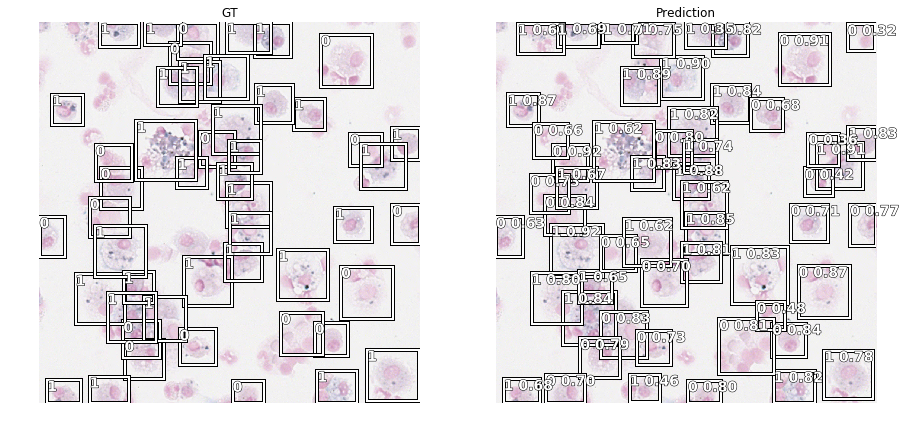

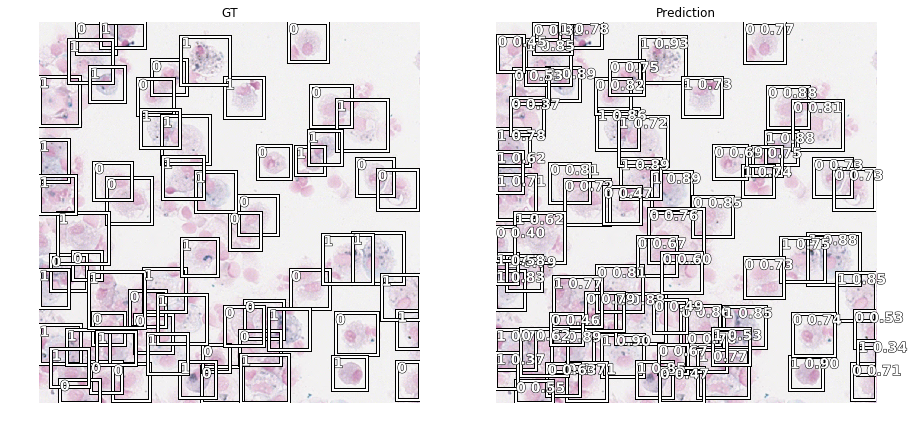

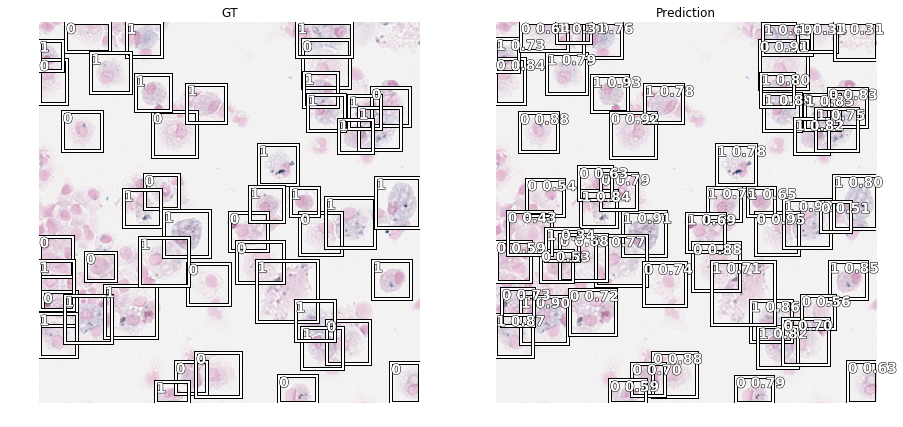

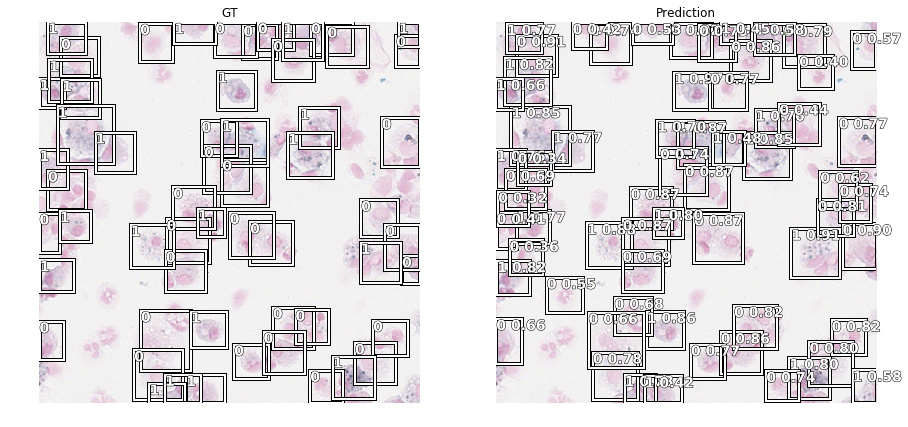

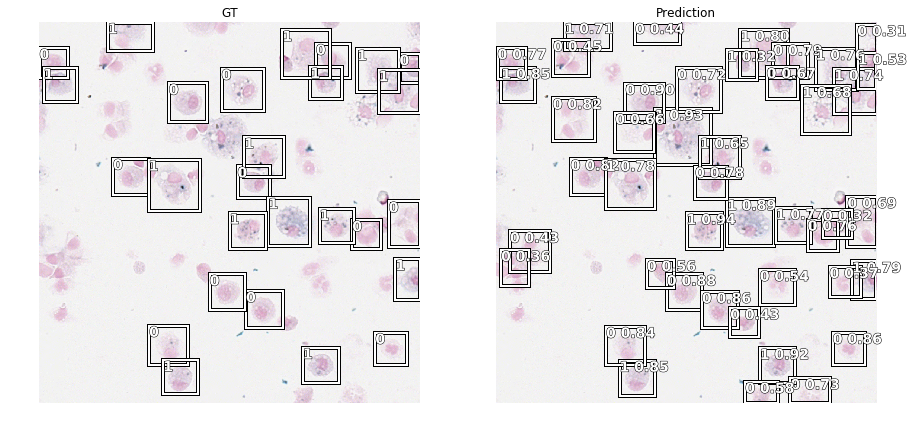

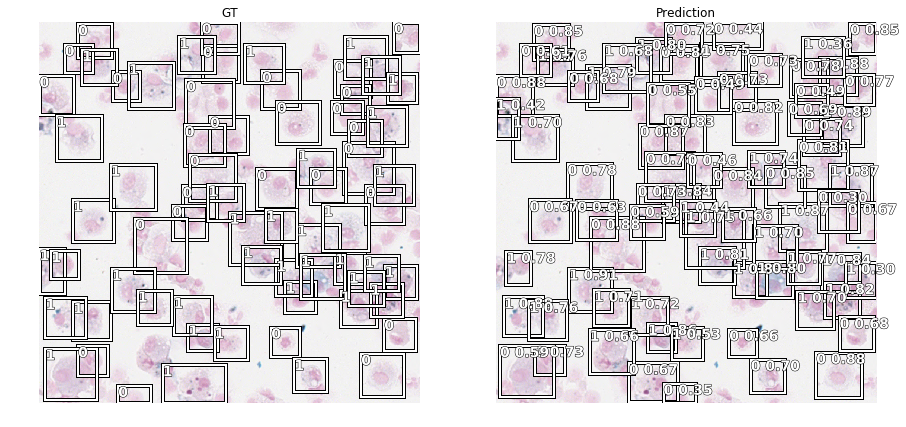

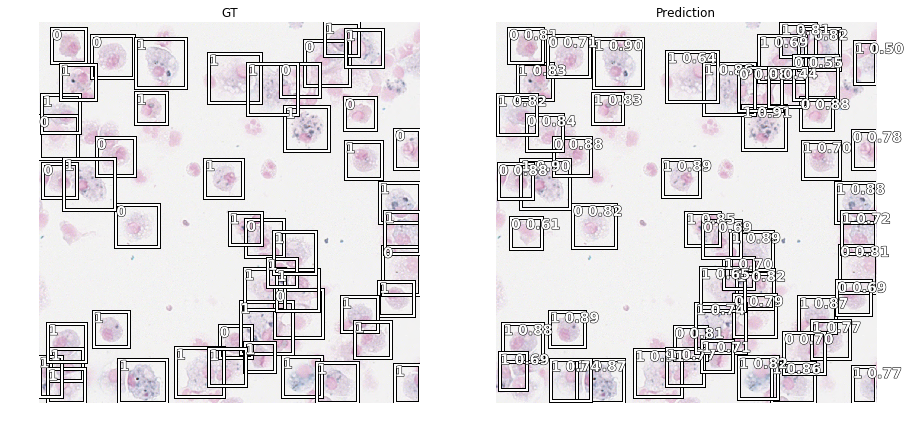

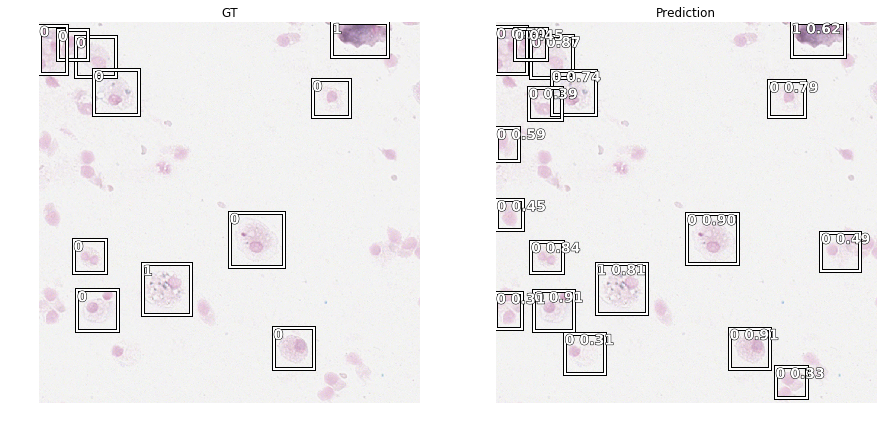

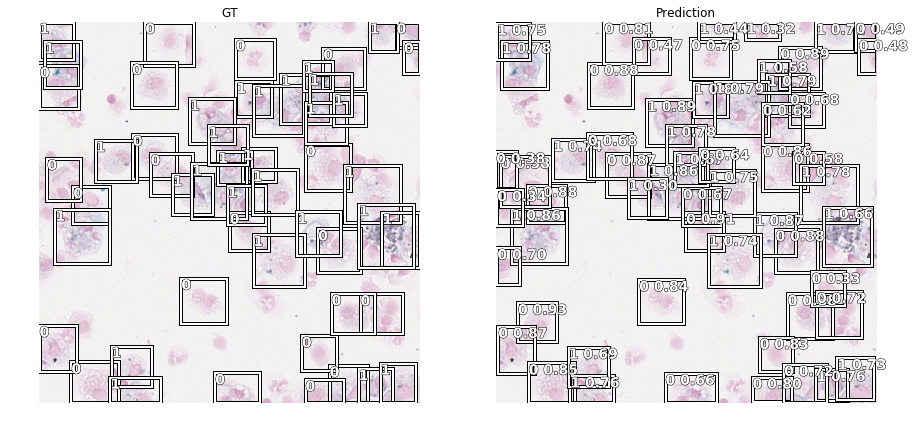

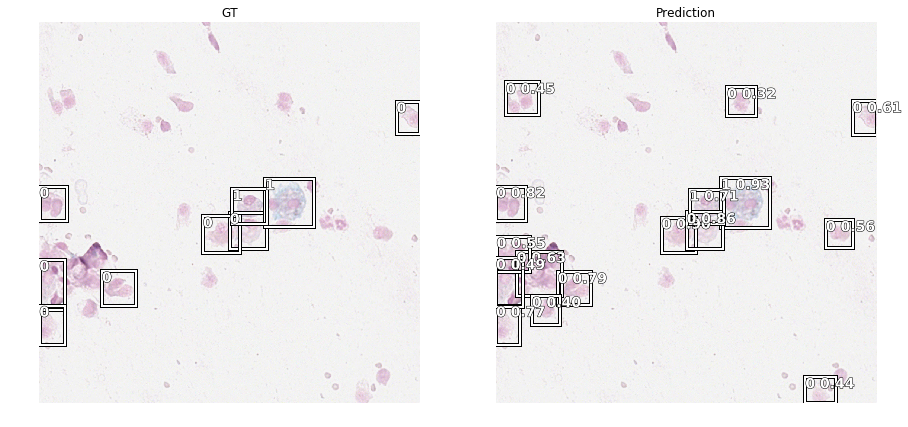

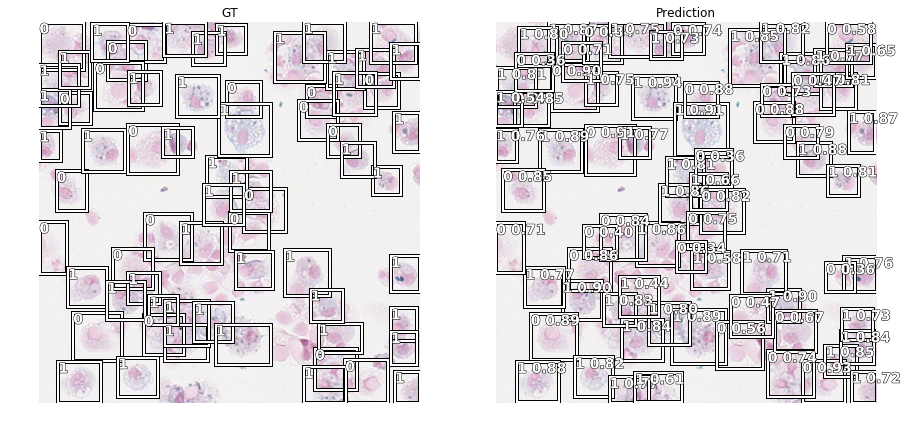

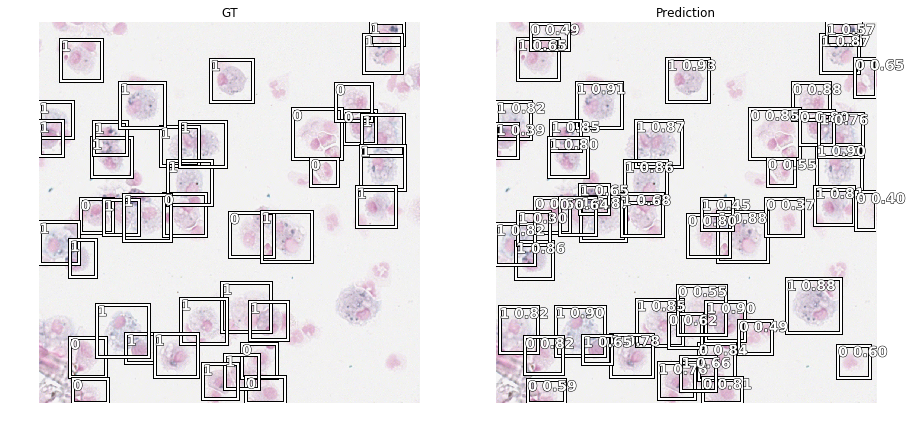

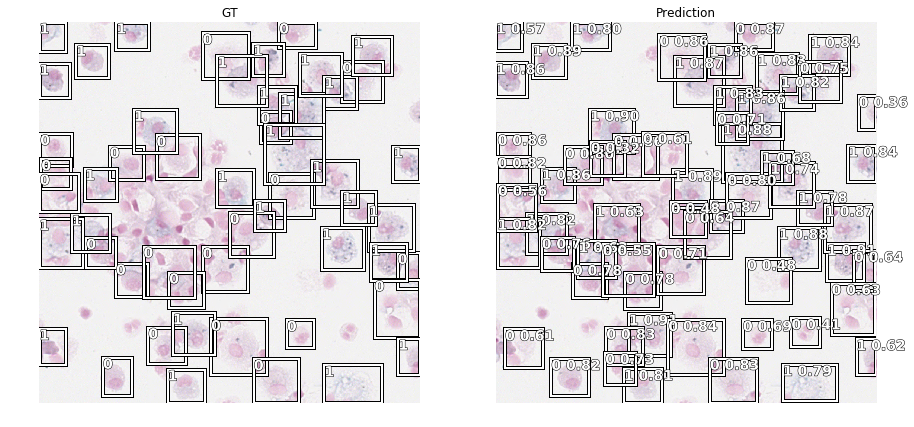

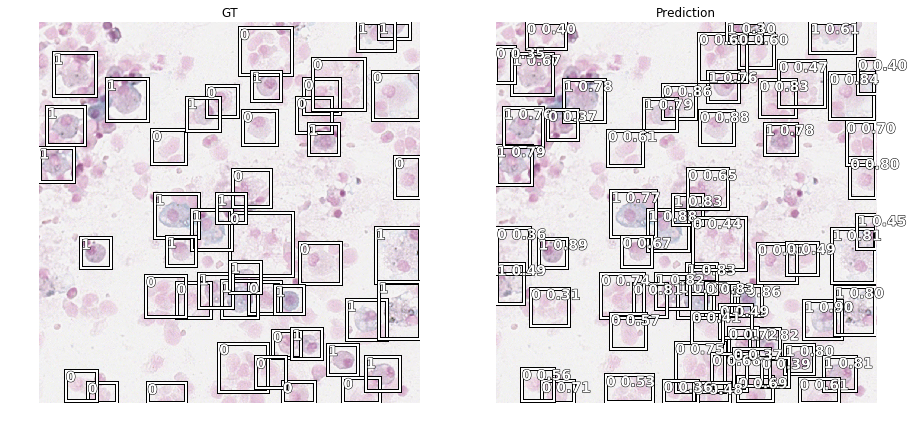

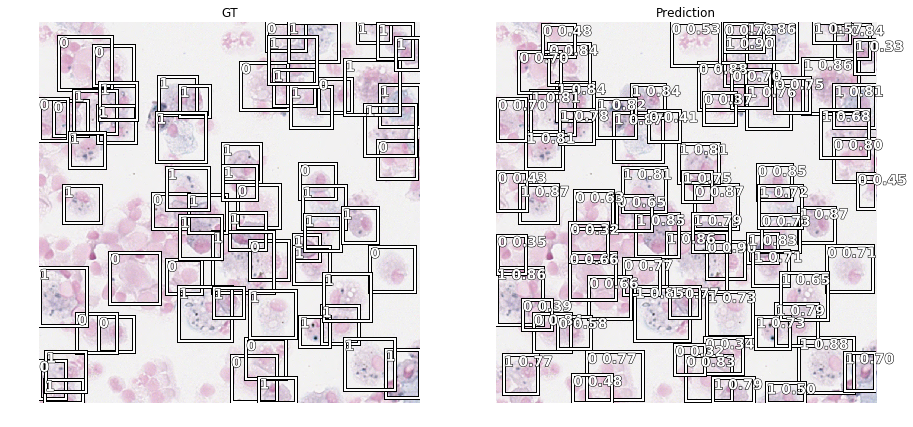

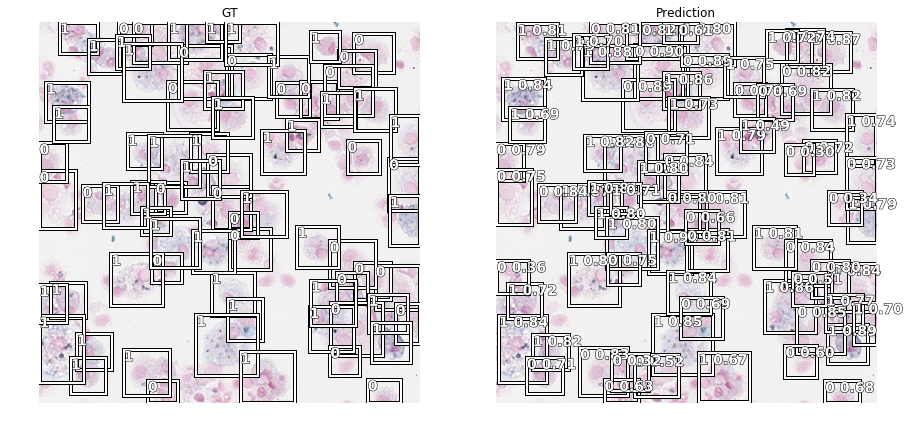

In [14]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=20)